In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB1  
from sklearn.model_selection import KFold
import os

# Define label-to-class and class-to-label mappings
label_to_class = {
    'Mild_Demented': 0,
    'Moderate_Demented': 1,
    'Non_Demented': 2,
    'Very_Mild_Demented': 3,
}

class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name="C:/Dataset", label_to_class=label_to_class):
    # Read images/labels from directory
    Images = []
    Classes = []
    for j in ["data"]:
        for label_name in os.listdir(os.path.join(dir_name, j)):
            cls1 = label_to_class[label_name]
            for img_name in os.listdir(os.path.join(dir_name, j, label_name)):
                # Load the image
                img = load_img(os.path.join(dir_name, j, label_name, img_name), target_size=(128, 128))  # Adjust size for EfficientNetB7
                # Convert the image to a NumPy array
                img = img_to_array(img)
                Images.append(img)
                Classes.append(cls1)

    Images = np.array(Images, dtype=np.float16)
    Classes = np.array(Classes, dtype=np.float16)
    Images, Classes = shuffle(Images, Classes, random_state=0)

    return Images, Classes

Images, Classes = get_images()
y_train_all = utils.to_categorical(Classes, num_classes=n_classes)

def EfficientNetModel(cf):
    inputs = tf.keras.layers.Input(shape=(128, 128, 3))

    
    # Pre-trained EfficientNetB7
    efficientnet = EfficientNetB1(include_top=False, weights="imagenet", input_tensor=inputs)
    output = efficientnet.output

    # Convolutional Layer
    x = Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu")(output)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)

    # Fully Connected Layers
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)

    logits = Dense(cf["num_classes"])(x)

    model = Model(inputs=inputs, outputs=logits)

    return model

def run_kfold_experiment(model, k=5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )

    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    fold = 1
    test_accuracies = []
    all_conf_matrices = []  # To store confusion matrices for each split
    all_class_reports = []  # To store classification reports for each split
    all_histories = []
    all_fprs = []  # To store false positive rates for each fold
    all_tprs = []  # To store true positive rates for each fold
   

    for fold, (train_idx, test_idx) in enumerate(kf.split(Images, y_train_all), 1):
        print(f"Training fold {fold}/{k}")
        x_train, x_test = Images[train_idx], Images[test_idx]
        y_train, y_test = y_train_all[train_idx], y_train_all[test_idx]
 
        history = model.fit(
            x_train,
            y_train,
            batch_size=64,
            epochs=20,
        )
        all_histories.append(history.history)

        # Evaluate the model on the test set to get test accuracy
        _, test_accuracy = model.evaluate(x_test, y_test)
        test_accuracies.append(test_accuracy)

        # Calculate and store the confusion matrix for this fold
        y_pred_fold = model.predict(x_test).argmax(axis=1)
        conf_matrix_fold = confusion_matrix(y_test.argmax(axis=1), y_pred_fold)
        all_conf_matrices.append(conf_matrix_fold)

        # Calculate and store the classification report for this fold
        class_report_fold = classification_report(y_test.argmax(axis=1), y_pred_fold, target_names=class_to_label.values(), output_dict=True)
        all_class_reports.append(class_report_fold)
        fold += 1

    print(f"Average Test accuracy: {round(np.mean(test_accuracies) * 100, 2)}%")
    return all_histories, all_conf_matrices, all_class_reports, all_fprs, all_tprs

config = {
    "num_classes": n_classes
}

# Create EfficientNetB7 model
with tf.distribute.MirroredStrategy().scope():
    efficientnet_classifier = EfficientNetModel(config)
    histories, conf_matrices, class_reports, all_fprs, all_tprs = run_kfold_experiment(efficientnet_classifier, k=5)






INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Training fold 1/5
Epoch 1/20
25/25 [==============================] - 363s 11s/step - loss: 1.0390 - accuracy: 0.5381
Epoch 2/20
25/25 [==============================] - 221s 9s/step - loss: 0.6018 - accuracy: 0.7400
Epoch 3/20
25/25 [==============================] - 152s 6s/step - loss: 0.3999 - accuracy: 0.8500
Epoch 4/20
25/25 [==============================] - 147s 6s/step - loss: 0.2768 - accuracy: 0.9094
Epoch 5/20
25/25 [==============================] - 145s 6s/step - loss: 0.1575 - accuracy: 0.9419
Epoch 6/20
25/25 [==============================] - 145s 6s/step - loss: 0.1091 - accuracy: 0.9631
Epoch 7/20
25/25 [==============================] - 144s 6s/step - loss: 0.0899 - accuracy: 0.9737
Epoch 8/20
25/25 [==============================] - 145s 6s/step - loss: 0.0763 - accuracy: 0.9719
Epoch 9/20
25/25 [==============================] - 143s 6s/step - loss: 0.0695 - accur

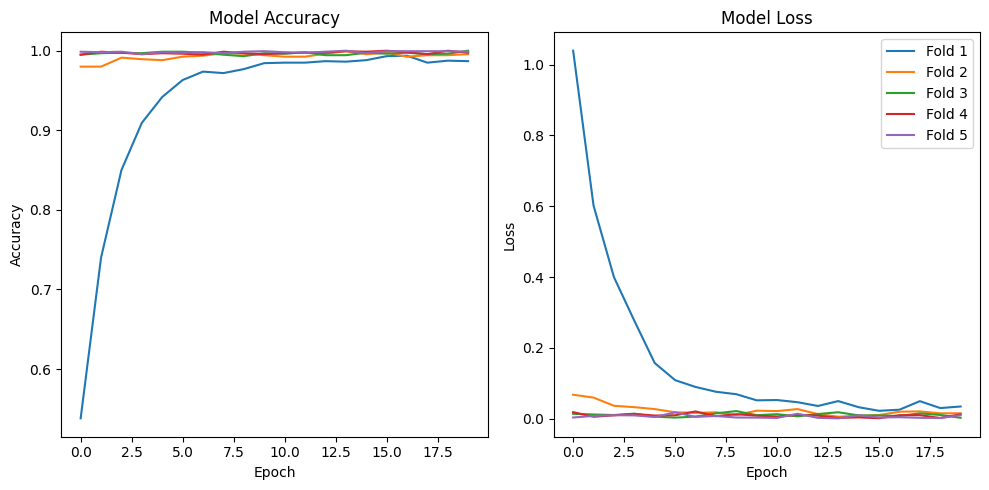

Classification Report - Fold 1:

{'Mild_Demented': {'precision': 0.9183673469387755, 'recall': 0.40540540540540543, 'f1-score': 0.5625, 'support': 111}, 'Moderate_Demented': {'precision': 0.697841726618705, 'recall': 1.0, 'f1-score': 0.8220338983050847, 'support': 97}, 'Non_Demented': {'precision': 0.5657894736842105, 'recall': 0.945054945054945, 'f1-score': 0.7078189300411523, 'support': 91}, 'Very_Mild_Demented': {'precision': 0.7833333333333333, 'recall': 0.46534653465346537, 'f1-score': 0.5838509316770186, 'support': 101}, 'accuracy': 0.6875, 'macro avg': {'precision': 0.7413329701437561, 'recall': 0.703951721278454, 'f1-score': 0.6690509400058139, 'support': 400}, 'weighted avg': {'precision': 0.7505823294103706, 'recall': 0.6875, 'f1-score': 0.6638881371717923, 'support': 400}}
------------------------------------------------------------
Classification Report - Fold 2:

{'Mild_Demented': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 86}, 'Moderate_Demented': {'pre

In [2]:
# Function to plot accuracy and loss
def plot_accuracy_loss(histories):
    plt.figure(figsize=(10, 5))
    
    for i, history in enumerate(histories):
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label=f'Fold {i+1}')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label=f'Fold {i+1}')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.legend()
    plt.show()
    # Plot accuracy and loss
plot_accuracy_loss(histories)

# Print classification reports for each fold
for i, class_report in enumerate(class_reports):
    print(f"Classification Report - Fold {i+1}:\n")
    print(class_report)
    print("-" * 60)

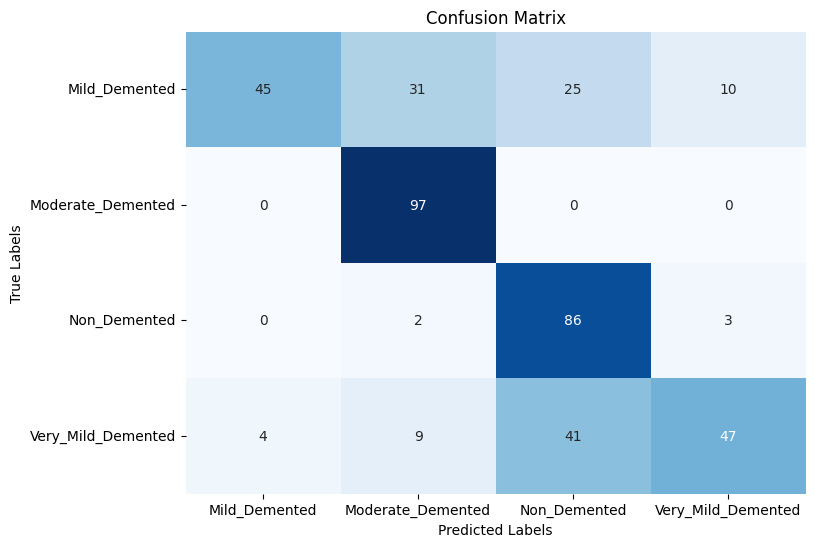

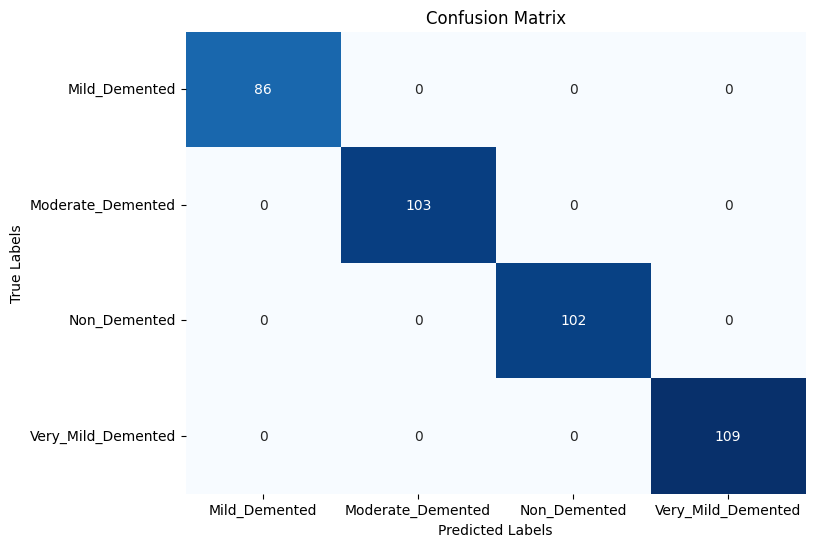

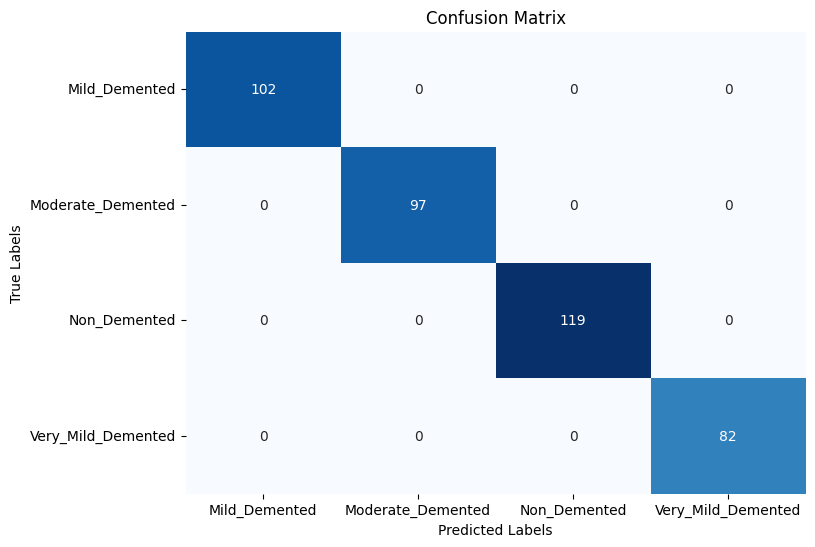

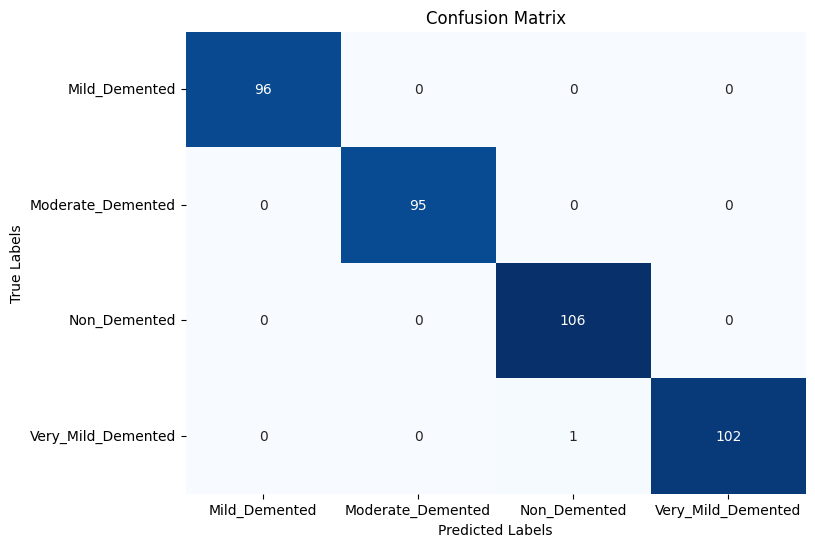

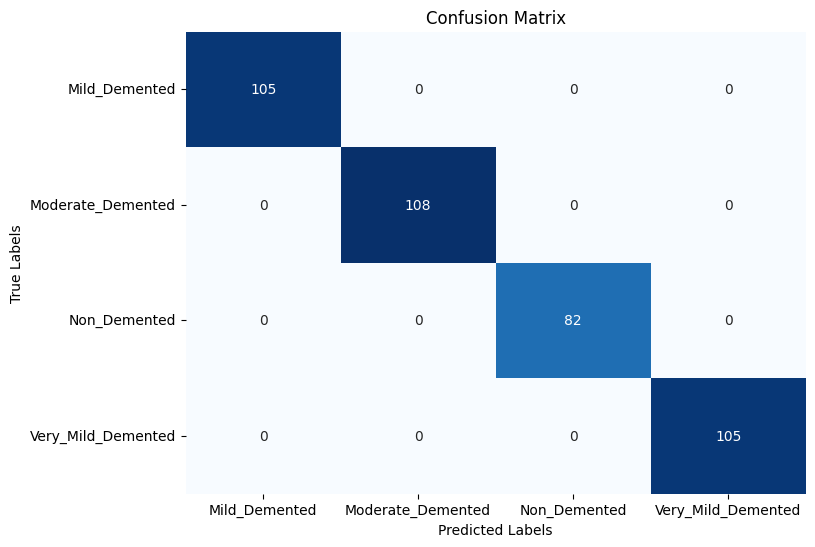

In [3]:
# Plot confusion matrix for each fold
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrices for each fold
for i, conf_matrix in enumerate(conf_matrices):
    class_names = [class_to_label[idx] for idx in range(n_classes)]
    plot_confusion_matrix(conf_matrix, class_names)